## Import modules

In [3]:
from GNNProject.utils import *
from GNNProject.dataset import *
from GNNProject.model import *
from GNNProject.classifier import *
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Initialize parameters
The parameters of the synthetic dataset are initialized. Also the grids for alpha parameters, number of training observations, and number of features are defiened. 

In [4]:
# dataset params
n_classes   = 3 
n_obs_test  = 5000 
n_char_features = 10
noise       = [0.2, 0.2]
model       = '‌‌BA'
syn_method  = 'sign'
random_seed = 42
# param grids
alpha_grid = np.arange(0.5, 10.5, 0.5).tolist()
n_obs_grid = [100, 200, 500, 1000]
n_features_grid = [100, 200, 300, 400, 500]

## EBIC based search & score
We iterate the grids in order to find the optimal alpha values based on the EBIC.

In [7]:
EBIC = np.zeros(len(alpha_grid))
scaler = StandardScaler()
NrFolds = 3
kf = KFold(n_splits=NrFolds)
dataset = Dataset(tag='optimal_alphas', random_seed=random_seed)
alpha_optim_grid = []
accuracy_optim_grid = []

for n_obs_s in n_obs_grid:
    for n_features_s in n_features_grid: 
        dataset.create_syn(n_classes   = n_classes, 
                    n_obs_train = n_obs_s, 
                    n_obs_test  = n_obs_test, 
                    n_features  = n_features_s,
                    n_char_features = n_char_features,
                    noise       = noise, 
                    model       = 'BA',
                    syn_method  = syn_method)  
        data_s = scaler.fit_transform(dataset.X_train)
        data = data_s

        for idx, alphas in enumerate(alpha_grid, start=0):
            for train_index, test_index in kf.split(data):
                X_trn, X_tst = data[train_index,:], data[test_index,:]
                _ , n_samples_trn = X_trn.shape
                cov_emp_trn = np.dot(X_trn.T, X_trn) / n_samples_trn
                covariance_trn, precision_matrix_trn = graphical_lasso(emp_cov=cov_emp_trn, alpha=alphas, mode='cd')
                n_features_tst, n_samples_tst = X_tst.shape
                cov_emp_tst = np.dot(X_tst.T, X_tst) / n_samples_tst
                covariance_tst, precision_matrix_tst = graphical_lasso(emp_cov=cov_emp_tst, alpha=alphas, mode='cd')
                EBIC[idx] = EBIC[idx] + ebic(covariance_trn, precision_matrix_tst, n_features_tst, n_samples_tst, gamma = 1)/NrFolds
       
        index_min_ebic = np.argmin(EBIC)
        alpha_optim_ebic = alpha_grid[index_min_ebic]
        dataset.create_graph(method='glasso_R', alphas=alpha_optim_ebic)
        accuracy_alpha_optim = dataset.score_graphs()[0][4]
        alpha_optim_grid = np.append(alpha_optim_grid, alpha_optim_ebic)  
        accuracy_optim_grid = np.append(accuracy_optim_grid, accuracy_alpha_optim) 

print(alpha_optim_grid)
print(accuracy_optim_grid)

[0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.
 3.  3. ]
[0.9452 0.9703 0.9801 0.9851 0.988  0.9428 0.9703 0.9801 0.9851 0.988
 0.9438 0.9703 0.9801 0.9851 0.988  0.9514 0.9707 0.9801 0.9851 0.988 ]


## Create a synthetic dataset
We create a synthetic dataset, visualize it into two dimentions. We then estimate the adjacency matrix with graphical lasso with the optimal value `alpha = 1`.  

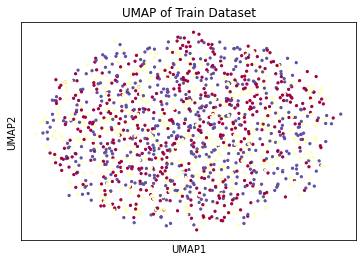

In [31]:
dataset.create_syn(n_classes   = n_classes, 
                    n_obs_train = 500, 
                    n_obs_test  = n_obs_test, 
                    n_features  = 100,
                    n_char_features = n_char_features,
                    noise       = noise, 
                    model       = 'BA',
                    syn_method  = syn_method)
    
plot_lowDim(dataset.X_train, dataset.y_train, title='UMAP of Train Dataset')
# plt.show()
plt.savefig('umap.png', dpi=1000)

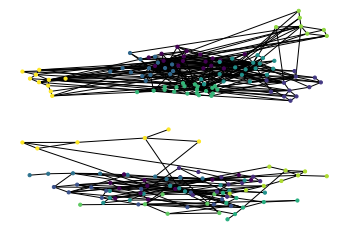

In [32]:
dataset.create_graph(method='glasso_R', alphas=1.0)
plt.subplot(211)
_ = draw_graph(dataset.A_train)
plt.subplot(212)
_ = draw_graph(dataset.Ah_train)
# plt.show()
plt.savefig('graphs.png', dpi=1000)